# Step #1 Load the Data

In [6]:
# A tutorial for this file will be shortly available at www.relataly.com
# Tested with python 3.9.13, matplotlib 3.6.2, seaborn 0.12.1, numpy 1.23.3, seaborn=0.12.1, chainer=7.8.1, plotly 5.11.0

import math # Fundamental package for scientific computing with Python
import numpy as np # Additional functions for analysing and manipulating data
import pandas as pd # Date Functions
import seaborn as sns
from datetime import date, timedelta # This function adds plotting functions for calender dates
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
import time
import matplotlib.pyplot as plt # Formatting dates
import copy
import chainer
import chainer.functions as F
import chainer.links as L
from plotly import subplots
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import plotly.graph_objects as go
import yfinance as yf #Alternative package if webreader does not work: pip install yfinance

# Setting the timeframe for the data extraction
end_date = date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting S&P500 quotes
stockname = 'S&P500'
symbol = '^GSPC'

df = yf.download(symbol, start=start_date, end=end_date)
df.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


# Step #2 Prepare the Data

<AxesSubplot: xlabel='Date', ylabel='Close'>

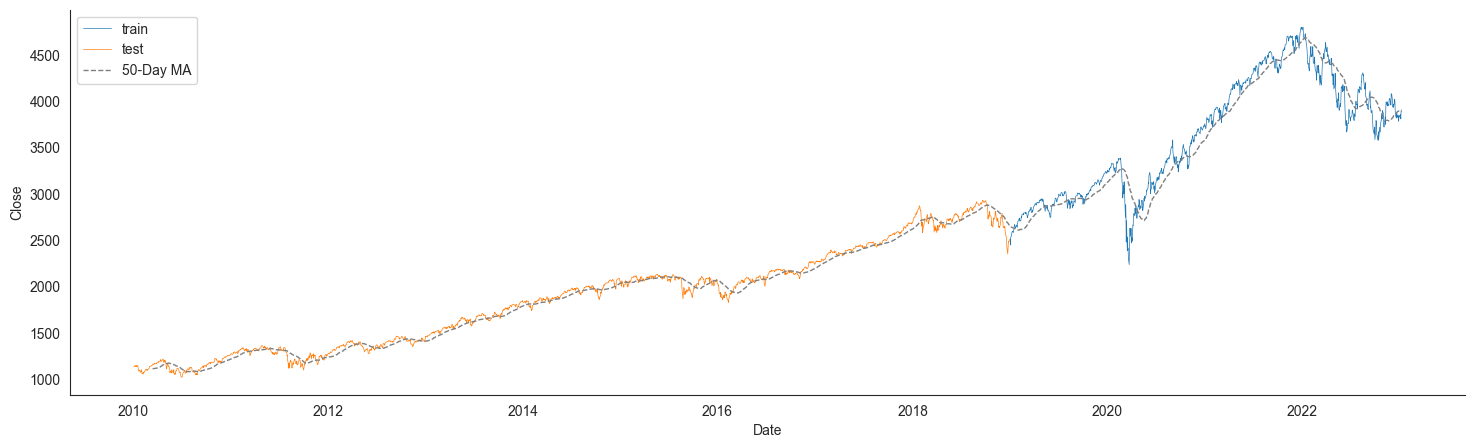

In [13]:
# Feature Selection - Only Close Data
df = df.filter(['Close', 'Open', 'Low', 'High', 'Volume'])

# Visualize the original time series
rolling_window=50
y_a_add_ma = df['Close'].rolling(window=rolling_window).mean() 
date_split = '2019-01-01'

# Create the training and test data
train = df[df.index > date_split] 
test = df[df.index <= date_split] 

fig, ax = plt.subplots(figsize=(18,5))
sns.lineplot(data=train, y='Close', x=train.index, linewidth=0.5, label='train', ax=ax)
sns.lineplot(data=test, y='Close', x=test.index, linewidth=0.5, label='test', ax=ax)
sns.lineplot(data=df, x=df.index, y=y_a_add_ma, 
    linewidth=1.0, color='grey', linestyle='--', label=f'{rolling_window}-Day MA')

In [17]:
class TradingEnvironment:
    def __init__(self, data, price_history):
        """
        Initialize the trading environment with the given data and price history.

        Parameters:
        - data: Pandas DataFrame containing the time series data with multivariate features
        - price_history: number of past prices to include in the observation
        """
        self.data = data
        self.price_history = price_history
        self.reset_environment()
    
    def reset_environment(self):
        """
        Reset the environment to the initial state.
        """
        self.time = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.portfolio_value = 0
        self.history = [0 for _ in range(self.price_history)]
        # Return the initial observation
        return [self.portfolio_value] + self.history
    
    def step(self, action):
        """
        Move the environment one step forward and let the agent see an additional data point.

        Parameters:
        - action: the action taken by the agent (0: hold, 1: buy, 2: sell)

        Returns:
        - observation: the new observation of the environment
        - reward: the reward for the action taken
        - done: whether the environment has reached its end
        """
        reward = 0
        if action == 1:  # buy
            self.positions.append(self.data.iloc[self.time, :]['Close'])
        elif action == 2:  # sell
            if not self.positions:  # agent does not have any positions
                reward = -1  # invalid action penalty
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.time, :]['Close'] - p)
                reward += profits
                self.positions = []
                self.profits += profits
        
        # Clip rewards
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1

        # Move to the next point in time
        self.time += 1
        self.portfolio_value = 0
        for p in self.positions:
            self.portfolio_value += (self.data.iloc[self.time, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.time, :]['Close'] - self.data.iloc[(self.time-1), :]['Close'])
        
        return [self.portfolio_value] + self.history, reward, self.done

# Create a new instance of the trading environment filled with training data
price_history = 80
env = TradingEnvironment(train, price_history)
print(env.reset_environment())
for _ in range(3):
    previous_action = np.random.randint(3)
    print(env.step(previous_action))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -62.14013671875], -1, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -62.14013671875, 84.050048828125], 0, False)
([17.75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
# this method starts the training process of the DQN
def train_dqn(env, epoch_num=50, step_max=None, train_freq=10, update_q_freq=20, memory_size=200, 
               batch_size=20, epsilon=1.0, epsilon_decrease=1e-3, epsilon_min=0.1, start_reduce_epsilon=200,
               gamma=0.97, show_log_freq=5):

    """Trains a Double DQN (Deep Q-Network) on the given environment.
        
    Args:
        env: The environment to train on.
        epoch_num: Number of epochs to train for.
        step_max: Maximum number of steps per epoch. If not specified, it is set to the number of data points in the environment.
        train_freq: Frequency of training (in number of steps).
        update_q_freq: Frequency of updating the target network (in number of steps).
        memory_size: Size of the memory buffer.
        batch_size: Batch size for training.
        epsilon: Initial value of epsilon (exploration-exploitation trade-off).
        epsilon_decrease: Decrease in epsilon per step.
        epsilon_min: Minimum value of epsilon.
        start_reduce_epsilon: Step at which to start decreasing epsilon.
        gamma: Discount factor.
        show_log_freq: Frequency of logging (in number of epochs).
    """

    class Q_Network(chainer.Chain):


        def __init__(self, input_size, hidden_size, output_size):
            """Initializes the network with the given number of neurons in each layer.
        
            Args:
            input_size: Number of neurons in the input layer.
            hidden_size: Number of neurons in the hidden layer.
            output_size: Number of neurons in the output layer.
            """
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            """Defines the forward pass of the network.
        
            Args:
            x: Input to the network.
            
            Returns:
            Output of the network.
            """
            h = F.relu(self.fc1(x))  # Apply ReLU activation to the output of the first hidden layer
            h = F.relu(self.fc2(h))  # Apply ReLU activation to the output of the second hidden layer
            y = self.fc3(h)  # Output layer
            return y

        # resets the network weights
        def reset(self):
            """Resets the gradients of the network."""
            self.zerograds()

    # Initialize the policy network and the target network. The input size of the first layer corresponds to the price history
    QN = Q_Network(input_size=env.price_history+1, hidden_size=env.price_history*2, output_size=3)
    QN_ast = copy.deepcopy(QN)

    # Set up the Adam optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(QN)
    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    print('\t'.join(map(str, [f'epochs\t', 'epsilon', 'total_step', 'log_reward', 'log_loss', 'elapsed_time_in_s'])))

    start = time.time()
    for epoch in range(epoch_num):

        # Reset the environment and initialize the episode
        previous_observation = env.reset_environment()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        step_max = len(env.data)-1

        # Run the episode until it is done or the maximum number of steps is reached
        while not done and step < step_max:

            # select an action
            previous_action = np.random.randint(3)
            if np.random.rand() > epsilon:
                previous_action = QN(np.array(previous_observation, dtype=np.float32).reshape(1, -1))
                previous_action = np.argmax(previous_action.data)

             # Take the action and observe the result
            observation, reward, done = env.step(previous_action)

            # Add the experience to the memory buffer
            memory.append((previous_observation, previous_action, reward, observation, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # Train or update the Q-value function
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    # Sample a batch of experiences from the memory buffer
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size], dtype=object)
                        b_previous_observation = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_previous_action = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_observation = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=bool)
                        
                        # Compute the target Q-values
                        q = QN(b_previous_observation)
                        indices = np.argmax(q.data, axis=1)
                        maxqs = QN_ast(b_observation).data
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_previous_action[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])

                        QN.reset()

                        # set the loss function against which we optimize the network weights
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    QN_ast = copy.deepcopy(QN)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            previous_observation = observation
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            epochnum = epoch+1
            log_reward = sum(total_rewards[((epochnum)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epochnum)-show_log_freq):])/show_log_freq
            elapsed_time = round(time.time()-start,0)
            print('\t'.join(map(str, [f'{epochnum}', epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return QN, total_losses, total_rewards


QN, total_losses, total_rewards = train_dqn(TradingEnvironment(train, price_history))

epochs		epsilon	total_step	log_reward	log_loss	elapsed_time_in_s


In [12]:

# This method initiates the training process of the network
def plot_train_test(train_env, test_env, Q):
    results = {'train': {'actions': [], 'rewards': []}, 'test': {'actions': [], 'rewards': []}}
    
    # Loop through the training and testing environments
    for env, phase in [(train_env, 'train'), (test_env, 'test')]:
        # Reset the environment
        previous_observation = env.reset_environment()

        # Loop through the data in the environment
        for _ in range(len(env.data)-1):
            # Get the action from the Q function
            previous_action = Q(np.array(previous_observation, dtype=np.float32).reshape(1, -1))
            previous_action = np.argmax(previous_action.data)

            # Store the action and reward
            results[phase]['actions'].append(previous_action)
            obs, reward, done = env.step(previous_action)
            results[phase]['rewards'].append(reward)

            # Set the new previous observation
            previous_observation = obs
        
    # Store the profits of the training and testing phases
    results['train']['profits'] = train_env.profits
    results['test']['profits'] = test_env.profits
    
    # Create a dataframe for each phase
    train_df = pd.DataFrame(results['train'])
    test_df = pd.DataFrame(results['test'])
    
    # Concatenate the dataframes
    df = pd.concat([train_df, test_df], keys=['train', 'test'])

    # Create the plot
    fig = go.Figure()
    
    plotdata = []
    def add_candlestick_plot(df, act, color):
        # Create a dataframe with only the rows where the action is equal to act
        plot_df = df[df['actions'] == act]

        # Add a candlestick plot to the figure
        plotdata.append(
            Candlestick(
                x=plot_df.index,
                open=plot_df['Open'],
                high=plot_df['High'],
                low=plot_df['Low'],
                close=plot_df['Close'],
                increasing=dict(line=dict(color=color)),
                decreasing=dict(line=dict(color=color))
            )
        )

    # Create copies of the training and testing data with the actions and rewards appended
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['actions'] = results['train']['actions'] + [np.nan]
    train_copy['reward'] = results['train']['rewards'] + [np.nan]
    test_copy['actions'] = results['test']['actions'] + [np.nan]
    test_copy['reward'] = results['test']['rewards'] + [np.nan]
    # Concatenate the training and testing data copies
    df_copy = pd.concat([train_copy, test_copy])  

    # Add candlestick plots for each action to the figure
    add_candlestick_plot(df_copy, 0, 'cyan') #hold
    add_candlestick_plot(df_copy, 1, 'green') #buy
    add_candlestick_plot(df_copy, 2, 'red') #sell
    
    layout = {
        'title': 'Actions and Rewards',
        'showlegend': False,
    }

    figure = Figure(data=plotdata, layout=layout)
    iplot(figure)
    

plot_train_test(TradingEnvironment(train, price_history), TradingEnvironment(test, price_history), QN) 

In [ ]:
def plot_loss_reward(total_losses, total_rewards):
    # Create the figure with two subplots
    figure = go.Figure(
        data=[
            go.Scatter(y=total_losses, mode='lines', name='Loss', line=dict(color='blue')),
            go.Scatter(y=total_rewards, mode='lines', name='Reward', line=dict(color='orangered'))
        ],
        layout=go.Layout(
            height=800,
            width=900,
            xaxis=dict(title='Epoch'),
            yaxis=dict(title='Loss / Reward'),
            showlegend=True
        )
    )

    # Show the figure
    figure.show()

# Call the plot function with the loss and reward data
plot_loss_reward(total_losses, total_rewards)